In [1]:
import matplotlib.pyplot as plt
from imutils import paths
import matplotlib as mpl
import tensorflow as tf
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-08 11:07:14.487709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

87.9 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
model.summary()

Model: "move_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Functional)       [(None, 7, 7, 1280),      706224    
                              (None, 14, 14, 288),               
                              (None, 28, 28, 96),                
                              (None, 56, 56, 96)]                
                                                                 
 FPN (Functional)            (None, 56, 56, 64)        113920    
                                                                 
 head (Functional)           (None, 56, 56, 17)        21137     
                                                                 
Total params: 841,281
Trainable params: 821,713
Non-trainable params: 19,568
_________________________________________________________________


In [6]:
for img, y in ds.take(1):
    heatmaps = model(img)
    print(y.shape)
    print(heatmaps.shape)

(10, 56, 56, 17)
(10, 56, 56, 17)


In [ ]:
def draw_sample(i):
    sample = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

    heatmaps = model.predict(img[i:i+1])

    colormap=cv2.COLORMAP_VIRIDIS
    alpha = .3
    
    # Heatmaps
    kptsmap = heatmaps[0, :, 1:].sum(axis=-1).reshape(GRID_SIZE, GRID_SIZE)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])
    kptsmap =(kptsmap * 255).astype('uint8')
    kptsmap = cv2.applyColorMap(kptsmap, colormap)

    centremap = heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])
    centremap =(centremap * 255).astype('uint8')
    centremap = cv2.applyColorMap(centremap, colormap)

    # Labels
    center_label = y[i, :, 0].numpy().reshape(GRID_SIZE, GRID_SIZE)
    center_label = cv2.resize(center_label, INPUT_SHAPE[:2])
    center_label =(center_label * 255).astype('uint8')
    center_label = cv2.applyColorMap(center_label, colormap)

    kpts_label = y[i, :, 1:].numpy().sum(axis=-1).reshape(GRID_SIZE, GRID_SIZE)
    kpts_label = cv2.resize(kpts_label, INPUT_SHAPE[:2])
    kpts_label =(kpts_label * 255).astype('uint8')
    kpts_label = cv2.applyColorMap(kpts_label, colormap)
    

    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    output = cv2.addWeighted(sample, alpha, center_label, 1 - alpha, 0)
    axs[0,0].imshow(output)
    axs[0,0].axis('off')
    axs[0,0].set_title("Label - CentreMap")

    output = cv2.addWeighted(sample, alpha, centremap, 1 - alpha, 0)
    axs[0,1].imshow(output)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted - CentreMap")

    output = cv2.addWeighted(sample, alpha, kpts_label, 1 - alpha, 0)
    axs[1,0].imshow(output)
    axs[1,0].axis('off')
    axs[1,0].set_title("Label - KeypointsMap")

    output = cv2.addWeighted(sample, alpha, kptsmap, 1 - alpha, 0)
    axs[1,1].imshow(output)
    axs[1,1].axis('off')
    axs[1,1].set_title("Predicted - KeypointsMap")

1/1 [==============================] - 1s 1s/step


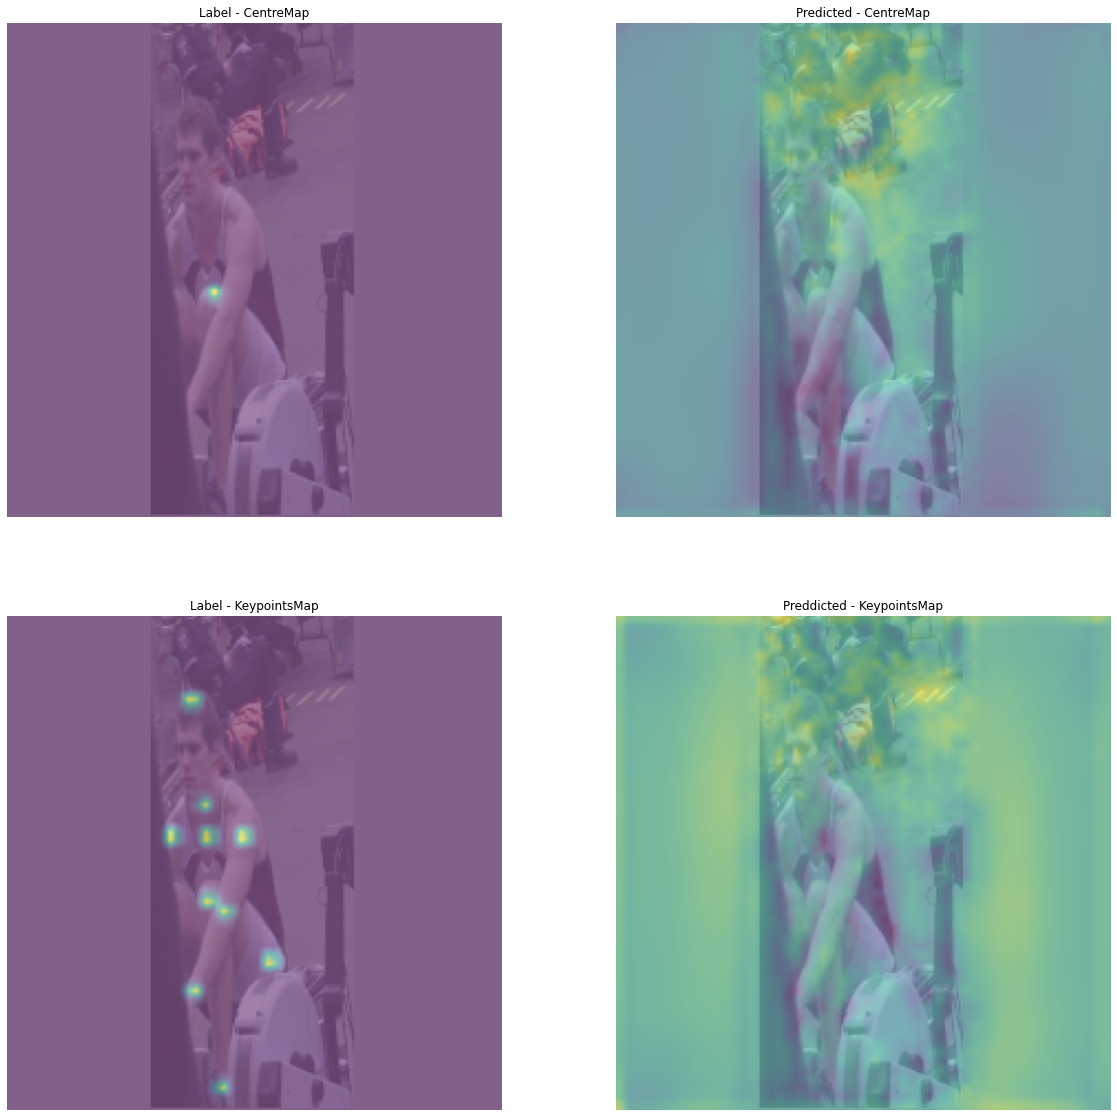

In [8]:
draw_sample(1)

In [9]:
tf.keras.losses.mae(y,y)

<tf.Tensor: shape=(10, 56, 56), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 